<a href="https://colab.research.google.com/github/guilhermegranchopro/Eco-AI.ly/blob/main/LSTM/Renewable_Percentage/Live_Predictions_LSTM_Renewable_Percentage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa: Implementação em Tempo Real

Usar a API do Electricity Maps para obter os últimos 24 datapoints de intensidade de carbono e alimentar a LSTM treinada para prever os próximos 24 valores na escala de 0 a 5.

1. Configurar a API do Electricity Maps:

  * Criar um script para buscar os últimos 24 valores de LCA via API.
  * Garantir que os dados obtidos estejam no mesmo formato do dataset original.

2. Pré-processar os Dados ao Vivo:

  * Converter timestamps corretamente.
  * Normalizar os dados para que fiquem no mesmo padrão usado no treinamento.

3. Carregar o Modelo Treinado:

  * Importar o modelo LSTM treinado armazenado no Google Drive.

4. Fazer a Previsão das Próximas 24 Horas:

  * Alimentar os dados ao vivo no modelo e obter a previsão.

5. Interpretar e Exibir a Previsão:

  * Converter as previsões na escala de 0 a 5.
  * Exibir os resultados de forma clara.

In [ ]:
# Script para Obter Dados ao Vivo e Fazer Previsão com a LSTM

import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib

In [ ]:
# Conectar ao Google Drive (necessário para carregar o modelo salvo)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configurações da API do Electricity Maps
API_KEY = 'czG7nq1wv9OHi1phrXUn'  # Chave da API fornecida
REGION = 'PT'  # Código da região (Portugal)
URL = f'https://api.electricitymap.org/v3/power-breakdown/history?zone={REGION}'
HEADERS = {'auth-token': API_KEY}

In [ ]:
# Função para obter os últimos 24 valores de LCA via API
def obter_dados_api():
    response = requests.get(URL, headers=HEADERS)
    if response.status_code == 200:
        data = response.json()['history']
        df = pd.DataFrame(data)
        df['datetime'] = pd.to_datetime(df['datetime'])  # Converter timestamps
        df = df.sort_values(by='datetime', ascending=True)  # Garantir ordem temporal
        df = df[['datetime', 'renewablePercentage']]  # Selecionar colunas relevantes
        df.rename(columns={'renewablePercentage': 'RP'}, inplace=True)
        return df.tail(24)  # Retornar as últimas 24 horas
    else:
        print(f"Erro ao acessar API: {response.status_code}")
        return None

In [ ]:
# Função para normalizar os dados com MinMaxScaler correto
def normalizar_dados(df):
    scaler = joblib.load('/content/drive/My Drive/Modelos/minmax_scaler_RP.pkl')

    print("Valor mínimo do treino:", scaler.data_min_)
    print("Valor máximo do treino:", scaler.data_max_)
    print("Fator de escala:", scaler.scale_)

    # Renomear a coluna para corresponder ao nome usado no treinamento
    df = df.rename(columns={'RP': 'Renewable Percentage'})

    # Aplicar transformação corretamente (sem fit_transform)
    df['Renewable Percentage'] = scaler.transform(df[['Renewable Percentage']])

    # Renomear a coluna de volta para "LCA" para manter a consistência do script
    df = df.rename(columns={'Renewable Percentage': 'RP'})

    return df

In [ ]:
# Função para carregar o modelo treinado
def carregar_modelo():
    modelo_path = '/content/drive/My Drive/Modelos/LSTM_RP_Model.keras'
    return tf.keras.models.load_model(modelo_path)

In [ ]:
# Função para prever a intensidade de carbono nas próximas 24 horas
def fazer_previsao(modelo, dados):
    dados_formatados = dados['RP'].values.reshape(1, 24, 1)  # Formatar para entrada da LSTM
    previsao = modelo.predict(dados_formatados)
    previsao_classe = np.argmax(previsao, axis=1)  # Obter a classe mais provável
    return previsao_classe

In [ ]:
# Executar o pipeline
print("Obtendo dados ao vivo...")
df_dados_atuais = obter_dados_api()
df_dados_atuais

Obtendo dados ao vivo...


,datetime,RP
0,2025-02-03 21:00:00+00:00,78
1,2025-02-03 22:00:00+00:00,81
2,2025-02-03 23:00:00+00:00,83
3,2025-02-04 00:00:00+00:00,86
4,2025-02-04 01:00:00+00:00,90
5,2025-02-04 02:00:00+00:00,89
6,2025-02-04 03:00:00+00:00,88
7,2025-02-04 04:00:00+00:00,87
8,2025-02-04 05:00:00+00:00,86
9,2025-02-04 06:00:00+00:00,81


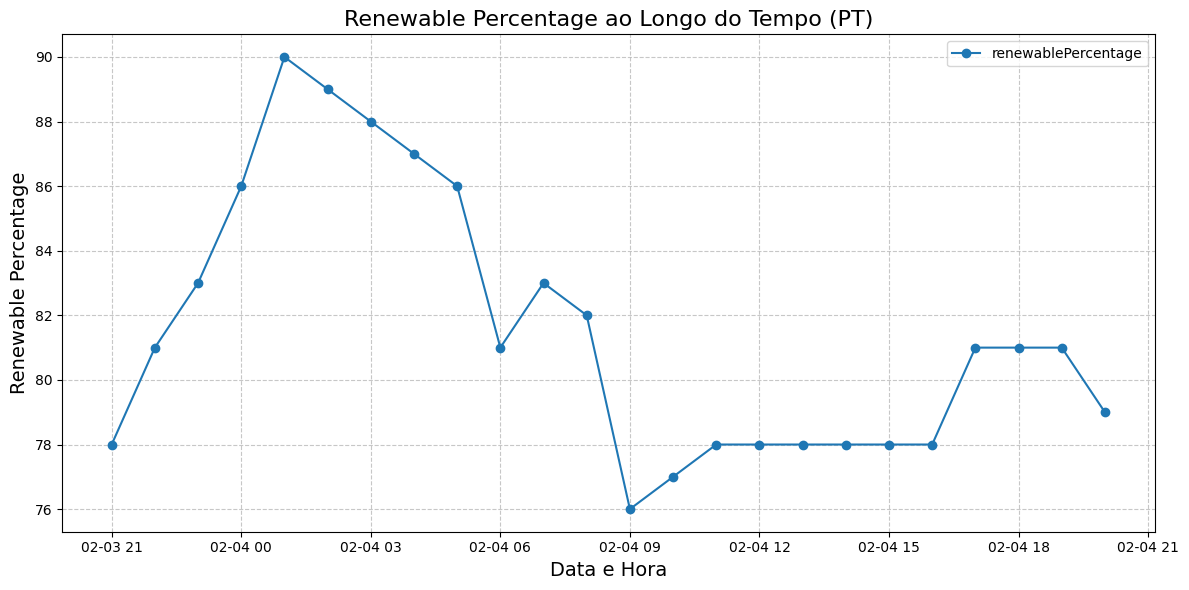

In [ ]:
# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(df_dados_atuais['datetime'], df_dados_atuais['RP'], marker='o', linestyle='-', label='renewablePercentage')
plt.title("Renewable Percentage ao Longo do Tempo (PT)", fontsize=16)
plt.xlabel("Data e Hora", fontsize=14)
plt.ylabel("Renewable Percentage", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Normalizando dados...")
df_dados_atuais = normalizar_dados(df_dados_atuais)

Normalizando dados...
Valor mínimo do treino: [14.7]
Valor máximo do treino: [99.13]
Fator de escala: [0.01184413]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


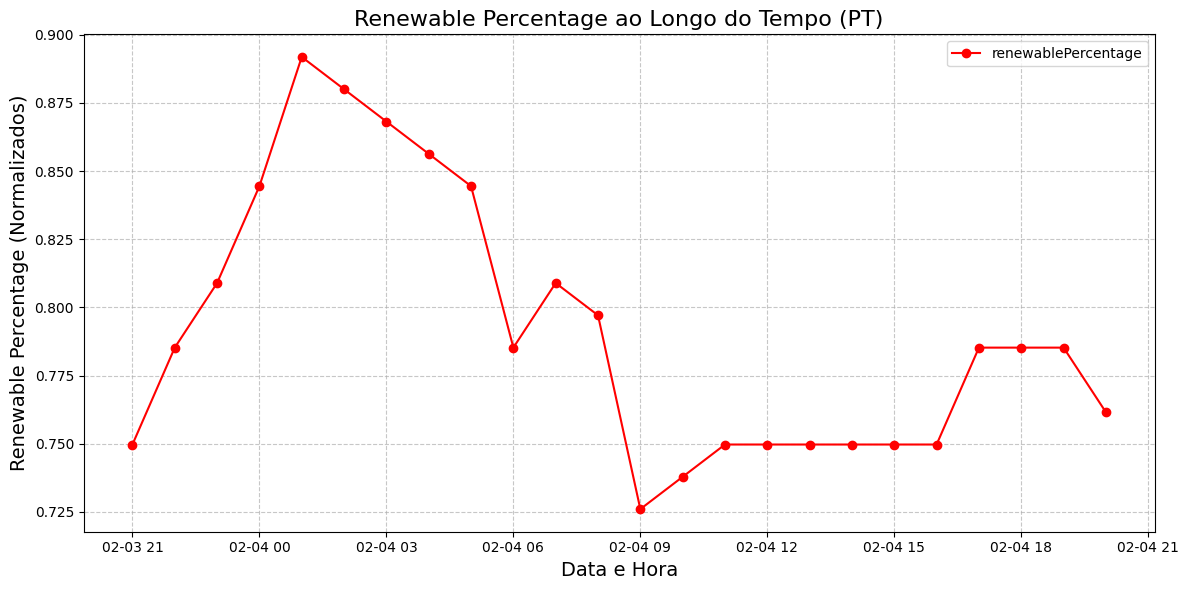

In [ ]:
# Plotando os dados
plt.figure(figsize=(12, 6))
plt.plot(df_dados_atuais['datetime'], df_dados_atuais['RP'], marker='o', linestyle='-', label='renewablePercentage', color='red')
plt.title("Renewable Percentage ao Longo do Tempo (PT)", fontsize=16)
plt.xlabel("Data e Hora", fontsize=14)
plt.ylabel("Renewable Percentage (Normalizados)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Carregando modelo...")
modelo = carregar_modelo()

Carregando modelo...


In [ ]:
print("Fazendo previsão para as próximas 24 horas...")
previsao = fazer_previsao(modelo, df_dados_atuais)

Fazendo previsão para as próximas 24 horas...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


In [ ]:
print("Previsão das próximas 24 horas (Escala 0 a 5):")
print(previsao)

Previsão das próximas 24 horas (Escala 0 a 5):
[5]
